# Data Preprocessing

In this notebook the JSONs extracted by the crawlers are loaded and normalized:
 - Dates are changed to the format **dd/mm/yyyy**
 - Texts are cleaned (removing non-alphabetic characters, lowering the case, etc.)
 

In [1]:
import re
import pandas as pd
import numpy as np
import json
import pickle as pkl
import os
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from unidecode import unidecode
from glob import glob

## Defining variables

In [2]:
PATH = '../'

RAW_DATA_PATH = os.path.join(PATH, 'data/raw/')

BOATOS_PATH = RAW_DATA_PATH + 'output.json'
ELPAIS_PATH = RAW_DATA_PATH + 'elpais.json'
G1_PATH = RAW_DATA_PATH + 'g1.json'

OUTPUT_PATH = os.path.join(PATH, 'data/processed/')

STOPWORDS = set(unidecode(sw) for sw in stopwords.words('portuguese'))

## Making FAKE NEWS DataFrame
### Loading JSON

In [3]:
with open(BOATOS_PATH, 'r') as f:
    boatos = json.load(f)
    
for i, item in enumerate(boatos):
    boatos[i]['text'] = ' '.join(item['text'])    

### Making DataFrame

In [4]:
df_fake = pd.DataFrame(boatos)
df_fake['FAKE'] = 1
df_fake['SOURCE'] = 'boatos.org'
df_fake.rename({'date': 'DATE', 'text': 'TEXT', 'title': 'TITLE'}, axis=1, inplace=True)

df_fake.head()

,DATE,TEXT,TITLE,FAKE,SOURCE
0,20/09/2019,“bolsonaro demite presidente da caixa e exige ...,\n \t\t\tBolsonaro demite presidente da Caix...,1,boatos.org
1,25/09/2019,"Todo mundo tinha certeza, inclusive quem era o...",\n \t\t\tMarcos Valério grava áudio falando ...,1,boatos.org
2,02/10/2019,,"\n \t\t\tDilma diz que, assim como Janot, ia...",1,boatos.org
3,20/09/2019,,\n \t\t\tBolsonaro traz ultrassom que destró...,1,boatos.org
4,06/10/2019,700 empresas do Japão querem investir no Brasi...,\n \t\t\t700 empresas querem investir no Bra...,1,boatos.org


In [5]:
df_fake.shape

(1301, 5)

## Making LEGIT NEWS DataFrame
### Loading JSONs

In [6]:
with open(G1_PATH, 'r') as f:
    g1 = json.load(f)
    
for i, item in enumerate(g1):
    g1[i]['text'] = ' '.join(item['text'])

with open(ELPAIS_PATH, 'r') as f:
    elpais = json.load(f)

for i, item in enumerate(elpais):
    elpais[i]['text'] = ' '.join(item['text'])

### Normalizing El Pais dates

In [7]:
month_dict = {
    'JAN': '01',
    'FEV': '02',
    'MAR': '03',
    'ABR': '04',
    'MAI': '05',
    'JUN': '06',
    'JUL': '07',
    'AGO': '08',
    'SET': '09',
    'SEP': '09',
    'OUT': '10',
    'NOV': '11',
    'DEZ': '12'
}

In [8]:
for i, item in enumerate(elpais):
    # Searching for dd/mmm/yyyy in the string
    matched = re.findall(r'\d+\s+[a-zA-Z]+\s+\d+', item['date'].strip())
    
    # If did not find anything, continues onto the next iteration
    if len(matched) == 0:
        continue
    
    date = matched[0]
    day = re.findall(r'\d+', date)[0]
    # Changing one digit days to two digits (e.g. 1/12/1999 to 01/12/1999)
    if len(day) == 1:
        date = date.replace(day + ' ', '0' + day + ' ')
    date = re.sub(r'\s+', ' ', date)
    date = re.sub(r'\s', '/', date)
    
    # Changing written month names to its numeric equivalent
    month = re.findall('[a-zA-Z]+', date)[0]
    if month in month_dict:
        date = re.sub(month, month_dict[month], date)
    
    elpais[i]['date'] = date

In [9]:
# Removing registers dated before 2013
for i, item in enumerate(elpais):
    if int(item['date'].split('/')[2]) < 2013:
        del elpais[i]

In [10]:
# Making sure the dates make sense
day = set()
month = set()
year = set()

for item in elpais:
    date = re.findall('\d+', item['date'])
    day.add(date[0])
    month.add(date[1])
    year.add(date[2])
    
print('Dias: ',len(day))
print('Meses', len(month))
print('Anos:', len(year), '-', year)

Dias:  31
Meses 12
Anos: 7 - {'2018', '2016', '2014', '2013', '2015', '2019', '2017'}


### Normalizing G1 dates

In [11]:
for i, item in enumerate(g1):
    matched = re.findall('\d+/\d+/\d+', g1[5]['date'].strip())
    if len(matched) == 0:
        continue
    g1[i]['date'] = matched[0]

### Making DataFrame

In [12]:
df_elpais = pd.DataFrame(elpais)
df_elpais['FAKE'] = 0
df_elpais['SOURCE'] = 'El País'

df_g1 = pd.DataFrame(g1)
df_g1['FAKE'] = 0
df_g1['SOURCE'] = 'G1'

df_legit = df_elpais.append(df_g1)
df_legit.rename({'date': 'DATE', 'text': 'TEXT', 'title': 'TITLE'}, axis=1, inplace=True)

df_legit.head()

,DATE,TEXT,TITLE,FAKE,SOURCE
0,04/06/2019,O atual mandato presidencial no Brasil começou...,Começam a soar os alarmes sobre a sustentabili...,0,El País
1,02/06/2019,Poucas horas antes de milhares de manifestant...,"Corte ou contingenciamento, quem está certo na...",0,El País
2,03/06/2019,Se o tamanho de uma figura pública se mede pel...,Trump insulta prefeito de Londres no início de...,0,El País
3,26/05/2019,Um dos tantos fenômenos imparáveis trazidos pe...,O líder e eu (e ninguém no meio),0,El País
4,03/06/2019,"Após semanas de audiências públicas, o projeto...",A reforma da Previdência pesará mais sobre os ...,0,El País


## Cleaning texts

In [13]:
stemmer = SnowballStemmer(language='portuguese')

def clean_text(text):
    # Making sure we're dealing with strings and lowering the characters
    text = str(text).lower()
    
    # Stemming tokens
    text = " ".join([stemmer.stem(wrd) for wrd in text.split()])
    
    # Stripping accents
    text = unidecode(text)
    
    # Removing characters that aren't alphanumeric
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text)
    
    # Removing tokens that intercalate between letters and digits
    text = re.sub(r'\w*([a-zA-Z][0-9]|[0-9][a-zA-Z])\w*', ' ', text)
    
    # Removing digits
    text = re.sub(r'\d', ' ', text)
    
    # Removing tokens with letters that appear more than twice in a row
    text = re.sub(r'\w*([a-zA-Z])\1{2,}\w*', ' ', text)
    
    # Removing extra spaces
    text = re.sub('\s+', ' ', text)
    
    # Removing words with length equal or lower than 2 or are in STOPWORDS
    return ' '.join([token for token in text.split() if len(token) > 2 and token not in STOPWORDS])

In [14]:
clean_text("Testando limpeza dos textos. Remoção de stopwords e outras coisas")

'test limpez textos remoca stopwords outr cois'

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
%matplotlib inline

Text(2, 1351, '1301')

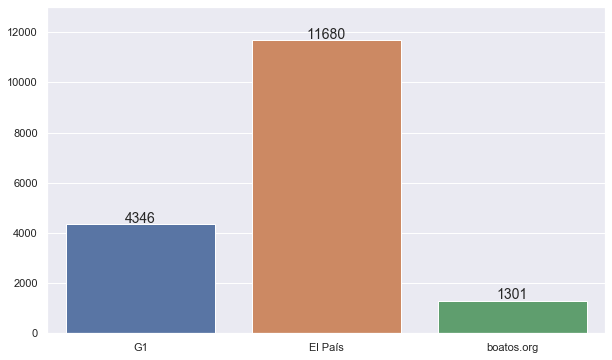

In [17]:
df = pd.concat((df_fake, df_legit), axis=0)

x = ['G1', 'El País', 'boatos.org']
y = [len(df[df['SOURCE'] == x[0]]),
     len(df[df['SOURCE'] == x[1]]),
     len(df[df['SOURCE'] == x[2]])]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x, y)
ax.set_ylim(0, 13000)
ax.text(0, y[0] + 50, y[0], fontsize=14, horizontalalignment="center")
ax.text(1, y[1] + 50, y[1], fontsize=14, horizontalalignment="center")
ax.text(2, y[2] + 50, y[2], fontsize=14, horizontalalignment="center")
# ax.set_title("Quantidade de dados de cada fonte", fontsize=16)

In [18]:
from collections import Counter
Counter(df[df['TEXT'].map(len) == 0]['SOURCE'])

Counter({'boatos.org': 407, 'El País': 240, 'G1': 81})

### Cleaning and dumping Fake News DataFrame

In [19]:
# Removing news that don't have any TEXT
df_fake = df_fake[df_fake['TEXT'].apply(len) > 0].reset_index(drop=True)

In [20]:
df_fake['TEXT_CLEAN'] = df_fake['TEXT'].apply(clean_text)
df_fake['TITLE_CLEAN'] = df_fake['TITLE'].apply(clean_text).apply(lambda x: re.sub('boato(|s)', '', x).strip())

In [21]:
df_fake['TEXT_LEN_CHAR'] = df_fake['TEXT_CLEAN'].apply(len)
df_fake['TEXT_LEN_TOKEN'] = df_fake['TEXT_CLEAN'].apply(str.split).apply(len)
df_fake['TITLE_LEN_CHAR'] = df_fake['TITLE_CLEAN'].apply(len)
df_fake['TITLE_LEN_TOKEN'] = df_fake['TITLE_CLEAN'].apply(str.split).apply(len)

In [22]:
df_fake['MONTH_YEAR'] = df_fake['DATE'].apply(lambda x: '/'.join(x.split('/')[1:]))

In [23]:
pkl.dump(df_fake, open(os.path.join(OUTPUT_PATH, 'df_fake_clean.pkl'), 'wb'))

### Cleaning and dumping Legit News Dataframe

In [24]:
# Removing news that don't have any TEXT
df_legit = df_legit[df_legit['TEXT'].apply(len) > 0].reset_index(drop=True)

In [25]:
df_legit['TEXT_CLEAN'] = df_legit['TEXT'].apply(clean_text)
df_legit['TITLE_CLEAN'] = df_legit['TITLE'].apply(clean_text)

In [26]:
df_legit['TEXT_LEN_CHAR'] = df_legit['TEXT_CLEAN'].apply(len)
df_legit['TEXT_LEN_TOKEN'] = df_legit['TEXT_CLEAN'].apply(str.split).apply(len)
df_legit['TITLE_LEN_CHAR'] = df_legit['TITLE_CLEAN'].apply(len)
df_legit['TITLE_LEN_TOKEN'] = df_legit['TITLE_CLEAN'].apply(str.split).apply(len)

In [30]:
df_legit['MONTH_YEAR'] = df_legit['DATE'].apply(lambda x: '/'.join(x.split('/')[1:]))

In [34]:
pkl.dump(df_legit, open(os.path.join(OUTPUT_PATH, 'df_legit_clean.pkl'), 'wb'))